In [1]:
from os.path import join
from os import walk

import warnings
warnings.filterwarnings(action='ignore')

from ToolKit import *

# # Activate reload of libraries
# %load_ext autoreload
# %autoreload 2

In [2]:
root_folder = r'.'
in_folder = root_folder
csv_files = [join(root, name)
             for root, dirs, files in walk(in_folder)
             for name in files
             if name.endswith('.csv')
             if 'mlvar_' in name
            ]
len(csv_files), csv_files

mlvar_dict = {}
for csv_file in csv_files[:]:
    df = pd.read_csv(csv_file,
                    )
    key = (csv_file[:-4]
           .split('\\')[-1]
           .split('_')[1]
          )
    mlvar_dict[key] = df

dict_mlvar = {}
new_columns = ['n0',
               'n1',
               'similarity',
              ]
for key, df in mlvar_dict.items():
    columns = df.columns
    new_df = pd.DataFrame(columns=new_columns,
                         )
    if columns[0]=='v1':
        new_df = pd.DataFrame(columns=new_columns,
                              data=(df
                                    .iloc[:,[0,1,4]]
                                    .values
                                   ),
                             )
    else:
        new_df = pd.DataFrame(columns=new_columns,
                              data=(df
                                    .iloc[:,[0,1,3]]
                                    .values
                                   ),
                             )
    dict_mlvar[key] = new_df

dict_mlvar

{'between':                    n0                 n1 similarity
 0          depression       hopelessness      0.425
 1              voices       hopelessness      0.014
 2              voices         depression     -0.027
 3             visions       hopelessness      0.015
 4             visions         depression      0.117
 5             visions             voices      0.421
 6             anxiety       hopelessness     -0.175
 7             anxiety         depression      0.741
 8             anxiety             voices      0.038
 9             anxiety            visions     -0.005
 10           paranoia       hopelessness     -0.255
 11           paranoia         depression      0.448
 12           paranoia             voices      0.201
 13           paranoia            visions     -0.247
 14           paranoia            anxiety      0.019
 15          delusions       hopelessness      0.118
 16          delusions         depression     -0.323
 17          delusions             

In [3]:
dict_graphs = {}
for key, df_mlvar in dict_mlvar.items():
    constructs = sorted(df_mlvar
                  .iloc[:,:2]
                  .stack()
                  .value_counts()
                  .keys()
                 )
    constructs_combinations = df_mlvar.values

    edges = {(c0,c1):float(v) for c0,c1, v in constructs_combinations}

    nodes = {q:{}
             for i, q 
             in enumerate(constructs)
            }

    # display_plot = Truenodes
    fontsize_node = 9.5

    max_distance = max([d for d in edges.values()])

    edges = {k:{'similarity':v,
                'absolute_similarity': abs(v),
               }
             for k,v
             in edges.items()
            }
    directional = True if key=='temporal' else False
    g = GraphBuilding(nodes,
                      edges,
                      directional=directional,
                     )

    betweenness = nx.betweenness_centrality(g,
                                            endpoints=True,
                                            weight='absolute_similarity',
                                           )
    closeness = nx.closeness_centrality(g,
                                        distance='absolute_similarity',
                                        wf_improved=True,
                                       )

    strength = {node:StrengthCentrality(g,
                                        node,
                                        'absolute_similarity',
                                       )
                for node
                in g.nodes()
               }
    nodes_centralities = {n:{name:c[n] 
                             for name, c
                             in [['betweenness', betweenness],
                                 ['strength', strength],
                                 ['closeness', closeness],
                                ]
                            } for n 
                          in nodes.keys()
                         }
    g = GraphBuilding(nodes_centralities,
                      edges,
                      directional=(True
                                   if key=='temporal' 
                                   else
                                   False
                                  ),
                     )
    key = (key
           if key!='between'
           else
           f'{key}-subjects'
          )
    dict_graphs[key] = g
dict_graphs

{'between-subjects': <networkx.classes.graph.Graph at 0x1c31ff35950>,
 'contemporaneous': <networkx.classes.graph.Graph at 0x1c31fece9e0>,
 'temporal': <networkx.classes.digraph.DiGraph at 0x1c31ff356d0>}

Graph with 9 nodes and 36 edges
Graph with 9 nodes and 36 edges
DiGraph with 9 nodes and 81 edges


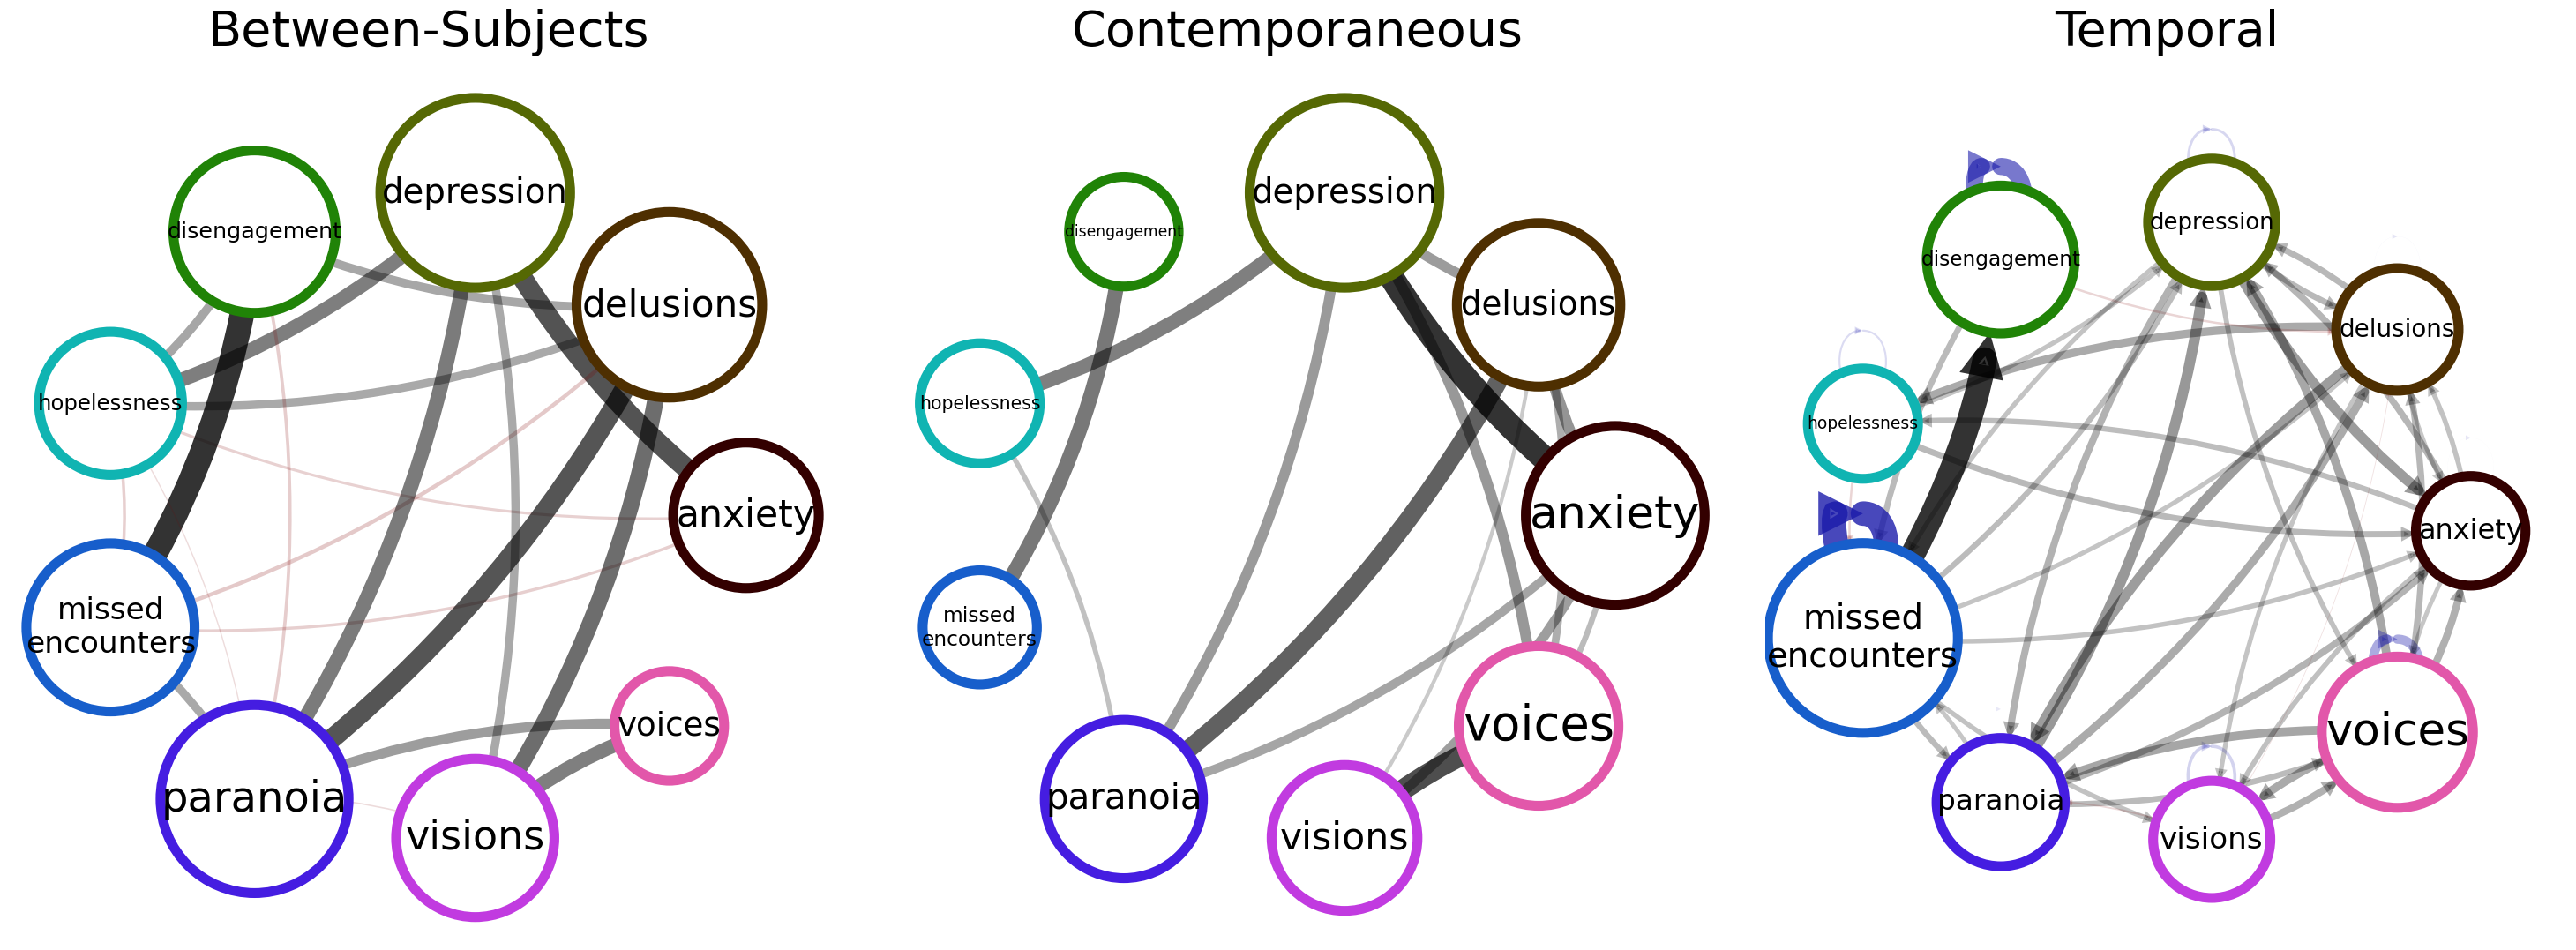

In [4]:
mlVARNetworkPlots(dict_graphs.items())